## Best Model Performance Metrics

### Model Evaluation Results

- R² Score: 0.931231247301555
- Mean Salary: 556116.5547756955
- Mean Absolute Error (MAE): 40941.674233490565
- Root Mean Squared Error (RMSE): 66986.5809956585
- Mean Squared Error (MSE): 4487202033.487916
- Average R² from 5-fold CV: 0.8087096331731203
- R² Score (Training): 0.9816594635946724
- R² Score (Test): 0.931231247301555


In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import os


In [86]:
df = pd.read_csv("/workspaces/CS_Group_09_Salary_prediction/data/Salary_Data.csv")
df_original = df.copy()

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [88]:
#Handle missing values 

df.dropna(inplace=True)

conversion_rate_inr_to_lkr = 4.96 

df['Salary'] = df['Salary']*conversion_rate_inr_to_lkr

In [89]:
#Remove duplicate rows

df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

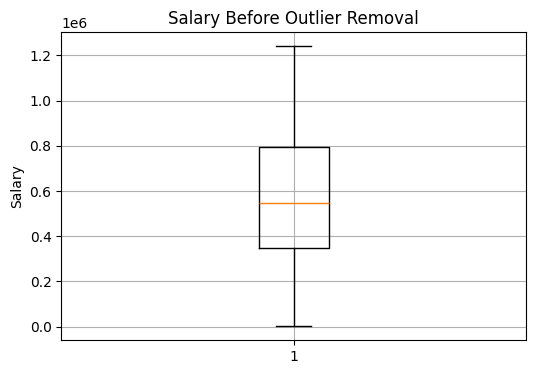

In [90]:
# Boxplot before outlier removal

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(df["Salary"])
plt.title("Salary Before Outlier Removal")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

# # Remove outliers using IQR method

# q1, q3 = np.percentile(df["Salary"], [25, 75])
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# # Filter the dataframe
# df = df[(df["Salary"] >= lower_bound) & (df["Salary"] <= upper_bound)]



In [91]:
#Remove outliers from all numerical columns using IQR 
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

# Filter out outliers for this column

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
#Reset index after filtering outliers

df.reset_index(drop=True, inplace=True)

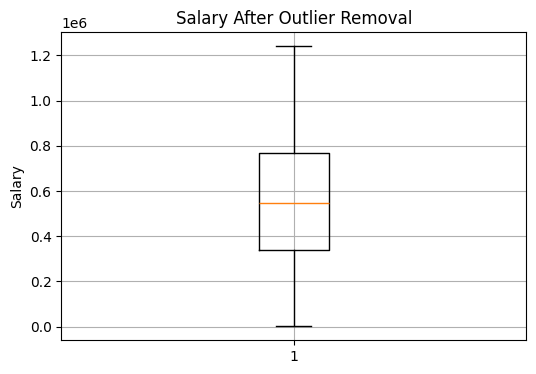

In [92]:
# Boxplot after outlier removal
plt.figure(figsize=(6, 4))
plt.boxplot(df["Salary"])
plt.title("Salary After Outlier Removal")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

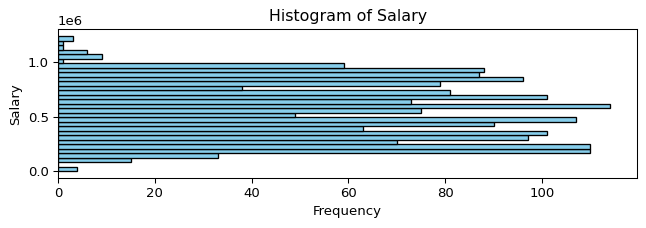

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Select only numerical columns
numeric_cols = ["Salary"]

# Create one subplot per numeric column
fig, axs = plt.subplots(len(numeric_cols), 1, dpi=95, figsize=(7, len(numeric_cols) * 2.5))

# Loop through each column and plot its histogram
for i, col in enumerate(numeric_cols):
    # Check if axs is a single Axes object or an array of Axes objects
    if len(numeric_cols) == 1:
        current_ax = axs
    else:
        current_ax = axs[i]

    current_ax.hist(df[col], bins=30, color='skyblue', edgecolor='black', orientation='horizontal') # Set orientation='horizontal' for horizontal histograms
    current_ax.set_title(f"Histogram of {col}")
    current_ax.set_xlabel("Frequency") # Swap xlabel and ylabel for horizontal
    current_ax.set_ylabel(col) # Swap xlabel and ylabel for horizontal

plt.tight_layout()
plt.show()

In [94]:
from scipy.stats import skew, kurtosis

print("Skewness:", skew(df['Salary']))
print("Kurtosis:", kurtosis(df['Salary']))

print("Original dataset size:", df_original.shape)
print("After removing outliers:", df.shape)
print(df.describe())


Skewness: 0.09642479691218127
Kurtosis: -1.0957167324545296
Original dataset size: (6704, 6)
After removing outliers: (1761, 6)
               Age  Years of Experience        Salary
count  1761.000000          1761.000000  1.761000e+03
mean     34.833049             8.863146  5.561166e+05
std       7.864077             6.430839  2.538540e+05
min      21.000000             0.000000  1.736000e+03
25%      29.000000             3.000000  3.372800e+05
50%      33.000000             8.000000  5.456000e+05
75%      41.000000            13.000000  7.688000e+05
max      58.000000            28.000000  1.240000e+06


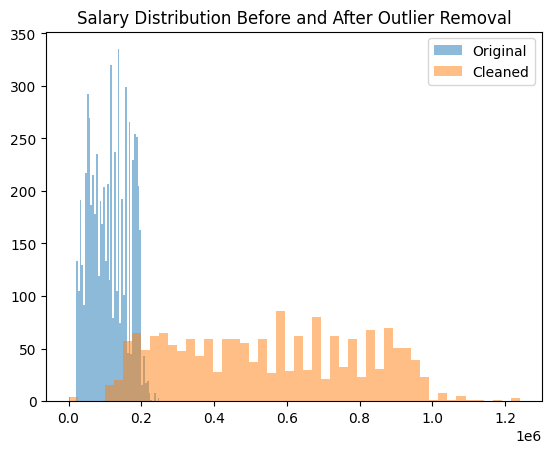

In [95]:
import matplotlib.pyplot as plt

plt.hist(df_original['Salary'], bins=50, alpha=0.5, label='Original')
plt.hist(df['Salary'], bins=50, alpha=0.5, label='Cleaned')
plt.legend()
plt.title("Salary Distribution Before and After Outlier Removal")
plt.show()

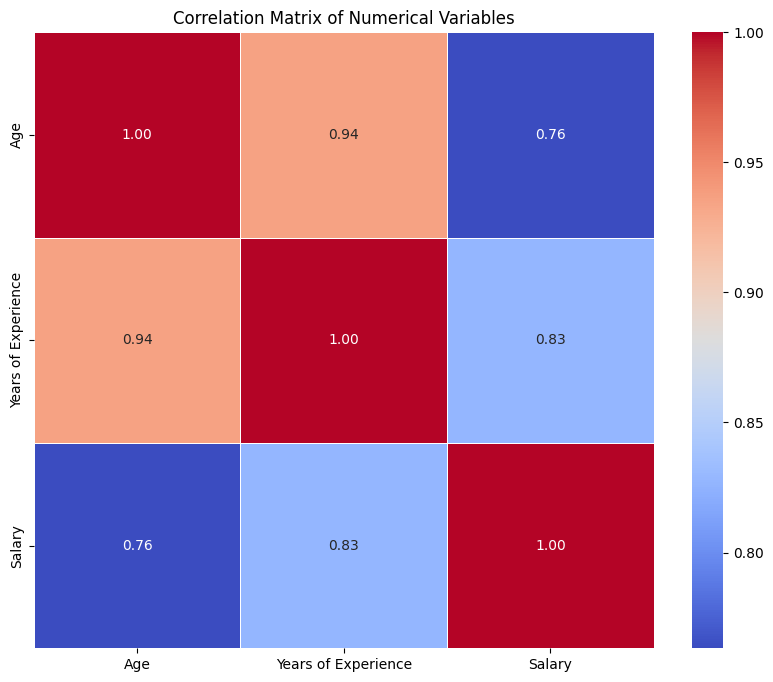

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [97]:
#Encode categorical variables

cat_cols = df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
else:
    print("No categorical columns to encode.")

In [98]:
correlation_with_target = df.corr()['Salary'].sort_values(ascending=False)
print(correlation_with_target)

Salary                                 1.000000
Years of Experience                    0.827170
Age                                    0.763189
Education Level_PhD                    0.440233
Job Title_Software Engineer Manager    0.288646
                                         ...   
Job Title_Sales Associate             -0.142570
Job Title_Junior HR Generalist        -0.150761
Job Title_Junior Sales Associate      -0.197108
Education Level_Bachelor's Degree     -0.273393
Education Level_High School           -0.347611
Name: Salary, Length: 201, dtype: float64


In [99]:
#Define features and target

X = df.drop('Salary', axis=1)
y = df['Salary']


In [100]:
#Train-test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [101]:
#Grid search hyperparameters

params = {
    # 'learning_rate': [0.1],
    # 'max_depth': [5],#[7],
    # 'n_estimators': [1000],#[200],
    # 'subsample': [0.9]#[0.8],
    'subsample': [0.9], 'reg_lambda':[ 10], 'reg_alpha':[ 0.5], 'random_state': [42], 'n_estimators': [1000], 'max_depth': [5], 'learning_rate': [0.1], 'gamma': [0.1], 'colsample_bytree': [1.0]
}

grid = GridSearchCV(XGBRegressor(), params, cv=5, scoring='r2')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


In [102]:
#Evaluate model on test set

y_pred = best_model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("Mean Salary:", y.mean())
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))


R² Score: 0.931231247301555
Mean Salary: 556116.5547756955
Mean Absolute Error (MAE): 40941.674233490565
Root Mean Squared Error (RMSE): 66986.5809956585
Mean Squared Error (MSE): 4487202033.487916


In [103]:
from sklearn.metrics import r2_score

# Predict on training data
y_train_pred = best_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Predict on test data (y_pred is already calculated in a previous cell)
r2_test = r2_score(y_test, y_pred)

print(f"R² Score (Training): {r2_train}")
print(f"R² Score (Test): {r2_test}")

R² Score (Training): 0.9816594635946724
R² Score (Test): 0.931231247301555


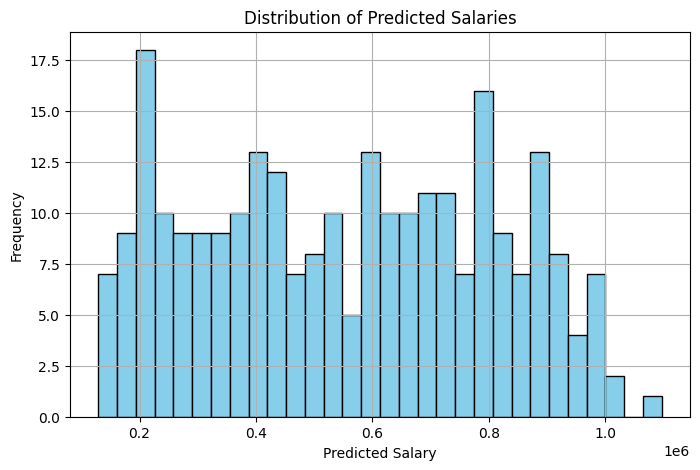

In [104]:
# Histogram of Predictions
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.hist(y_pred, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Salaries")
plt.xlabel("Predicted Salary")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


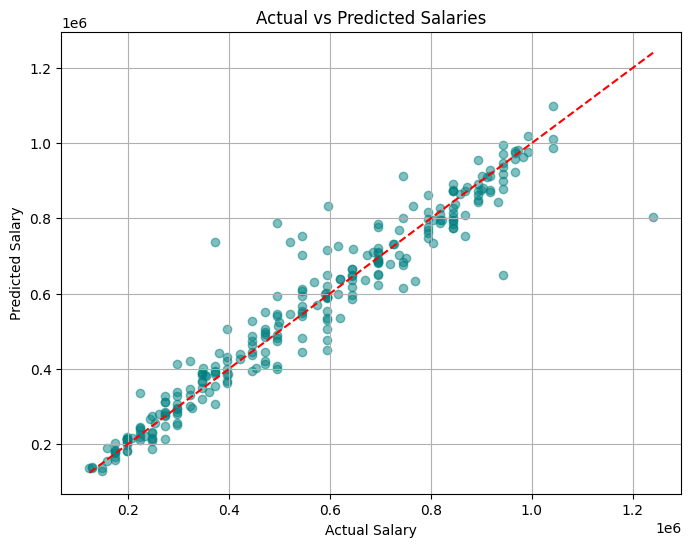

In [105]:
# Scatter Plot: True vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.title("Actual vs Predicted Salaries")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.grid(True)
plt.show()


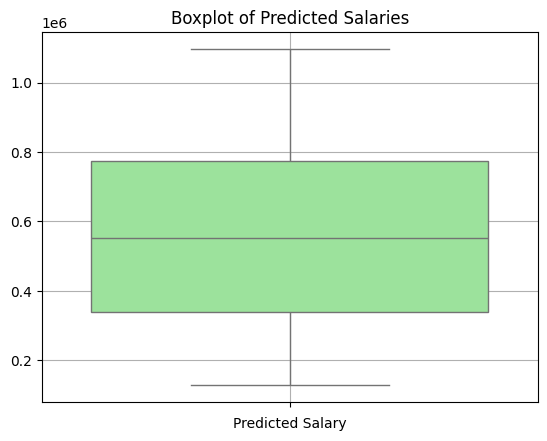

In [106]:
# Boxplot of Predicted Salaries
import seaborn as sns

sns.boxplot(y=y_pred, color='lightgreen')
plt.title("Boxplot of Predicted Salaries")
plt.xlabel("Predicted Salary")
plt.grid(True)
plt.show()


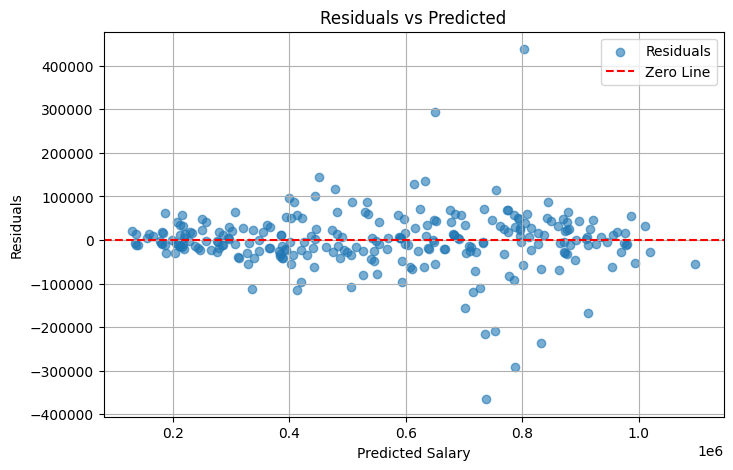

In [107]:
# Plot Residuals - Visualize the errors between predicted and actual values.
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.legend(['Residuals', 'Zero Line'])
plt.grid(True)
plt.show()


In [108]:
#Cross-validation R²

cv_scores = cross_val_score(best_model, X, y, cv=10, scoring='r2')
print("Average R² from 5-fold CV:", cv_scores.mean())


Average R² from 5-fold CV: 0.8087096331731203


In [109]:
#Save the trained model 

joblib.dump(best_model, "model3.pkl")

['model3.pkl']